# Local background estimation

`opticam_new` supports specification of local background estimators, which can improve the background estimation in cases where the background varies considerably across an image. In this notebook, I will demonstrate how to define a local background estimator for use with `opticam_new`, as well as explain `opticam_new`'s default local background estimator.

## `DefaultLocalBackground`

Let's first see how the default local background estimator works and performs. To demonstrate local background estimators, I find it most instructive to use them in data reduction. Therefore, the first few steps in this tutorial are largely the same as in the [Basic Usage tutorial](basic_usage.ipynb).

Generate some synthetic data:

In [1]:
from opticam_new.generate import create_synthetic_observations, create_synthetic_flats

create_synthetic_observations(out_dir='local_backgrounds_tutorial/data')  # generate some synthetic observations
create_synthetic_flats(out_dir='local_backgrounds_tutorial/flats')  # generate some synthetic flat-field images

Creating synthetic observations: 100%|██████████|[00:05<00:00]
Creating synthetic flats: 100%|██████████|[00:00<00:00]


Define a catalogue:

[OPTICAM] local_backgrounds_tutorial/reduced/ not found, attempting to create ...
[OPTICAM] local_backgrounds_tutorial/reduced/ created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 100 g-band images.
[OPTICAM] 100 r-band images.
[OPTICAM] 100 i-band images.


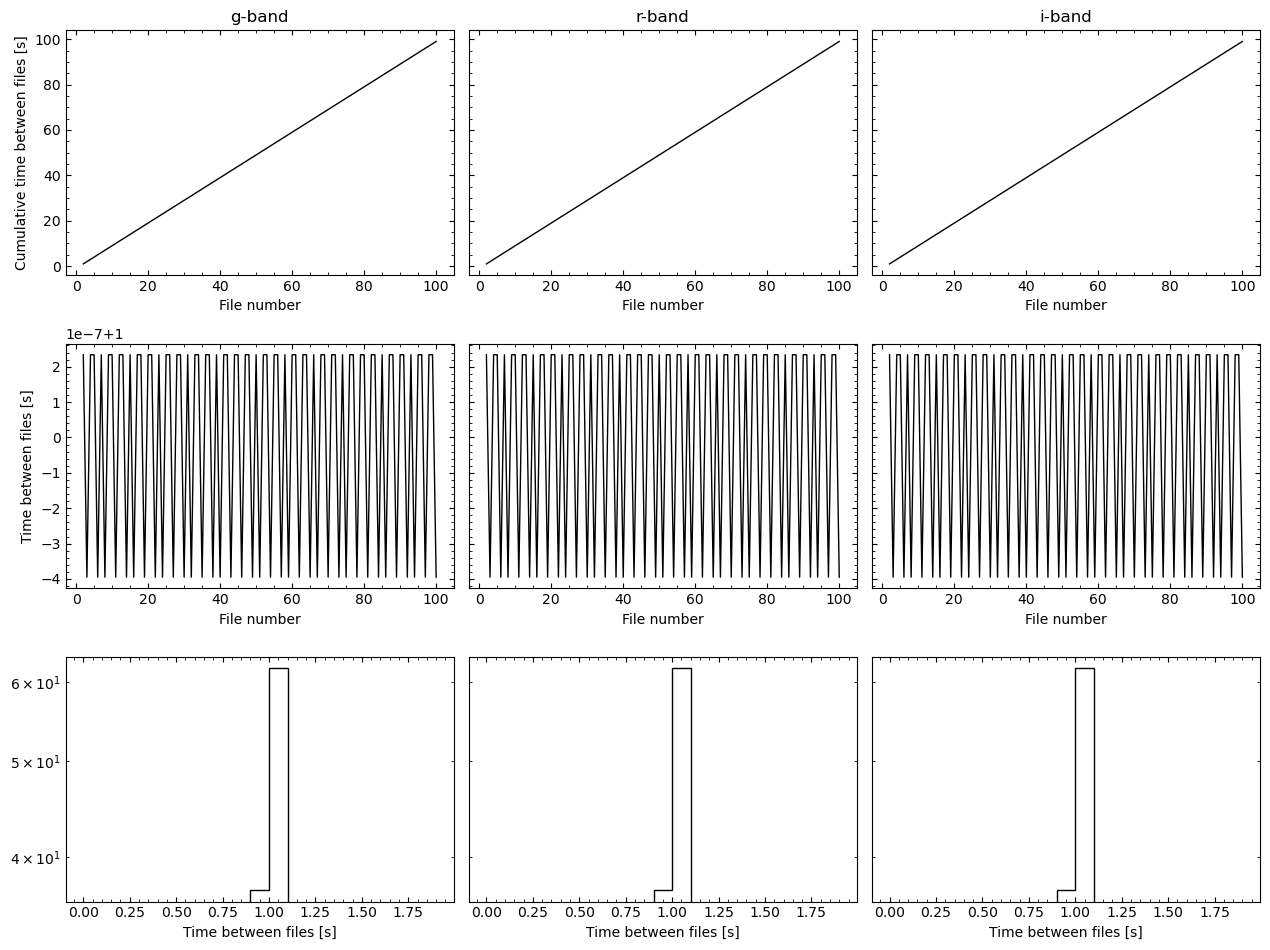

In [2]:
from opticam_new import Catalogue
from opticam_new.correctors import FlatFieldCorrector

flat_corr = FlatFieldCorrector(
    out_dir='local_backgrounds_tutorial/master_flats',
    flats_dir='local_backgrounds_tutorial/flats',
    )

cat = Catalogue(
    data_directory='local_backgrounds_tutorial/data',
    out_directory='local_backgrounds_tutorial/reduced',
    remove_cosmic_rays=False,
    flat_corrector=flat_corr,
    )

Initialise the catalogue:

[OPTICAM] Initialising catalogues ...
[OPTICAM] g-band master flat-field image not found. Attempting to create...
[OPTICAM] Master flat-field image created.


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


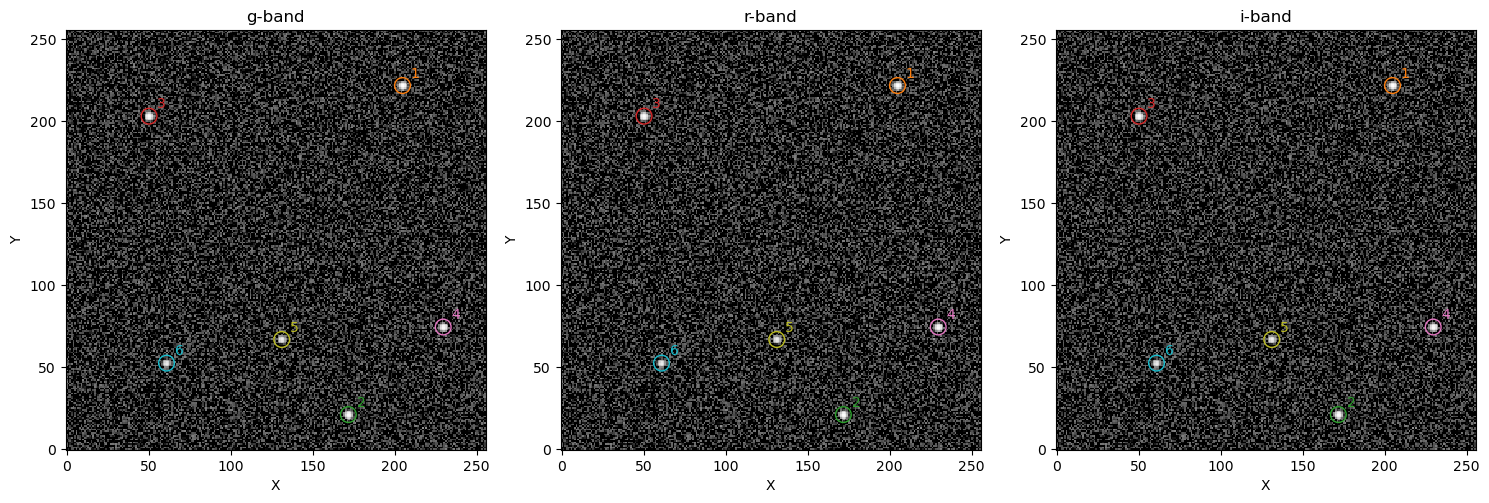

In [3]:
cat.initialise()

Now we can define a photometer using the default local background estimator, `DefaultLocalBackground`. The default local background estimator uses an elliptical annulus that scales the `semimajor_sigma` and `semiminor_sigma` parameters of the catalogue's `psf_params` dictionary, so let's see what this dictionary looks like first:

In [4]:
cat.psf_params

{'g-band': {'semimajor_sigma': np.float64(0.9587293314832883),
  'semiminor_sigma': np.float64(0.9187686720783934),
  'orientation': np.float64(-56.09333875508239)},
 'r-band': {'semimajor_sigma': np.float64(0.9587293314832883),
  'semiminor_sigma': np.float64(0.9187686720783934),
  'orientation': np.float64(-56.09333875508239)},
 'i-band': {'semimajor_sigma': np.float64(0.9587293314832883),
  'semiminor_sigma': np.float64(0.9187686720783934),
  'orientation': np.float64(-56.09333875508239)}}

We can see that all three cameras have the same PSF parameters, since these simulated data are the same for each camera. In practise, the PSF parameters will generally be different between cameras. 

We can see each camera has three PSF parameters:
- `semimajor_sigma`: the standard deviation of the PSF along the semi-major axis (assuming a 2D Gaussian PSF)
- `semiminor_sigma`: the standard deviation of the PSF along the semi-minor axis (assuming a 2D Gaussian PSF)
- `orientation`: the orientation of the PSF in degrees

When defining a custom local background estimator, it's a good idea to use these values to define your annulus (more on this later). For now, let's perform photometry using the default local background estimator:

In [5]:
from opticam_new.local_background import DefaultLocalBackground
from opticam_new.photometers import OptimalPhotometer

from astropy.stats import SigmaClip

phot = OptimalPhotometer(
    local_background_estimator=DefaultLocalBackground(
        r_in_scale=5,  # default inner radius scale (in standard deviations, assuming a 2D Gaussian PSF)
        r_out_scale=6,  # default outer radius scale (in standard deviations, assuming a 2D Gaussian PSF)
        # sigma clipper to remove outliers in the annulus
        sigma_clip=SigmaClip(
            sigma=3,
            maxiters=10,
            )
        ),
)

cat.photometry(phot)

[OPTICAM] Performing photometry for g-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal_annulus photometry results for g-band sources: 100%|██████████| 6/6 [00:00<00:00, 1064.68it/s]
[OPTICAM] Performing photometry for r-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal_annulus photometry results for r-band sources: 100%|██████████| 6/6 [00:00<00:00, 1065.04it/s]
[OPTICAM] Performing photometry for i-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal_annulus photometry results for i-band sources: 100%|██████████| 6/6 [00:00<00:00, 1118.83it/s]


Let's take a look at the resulting light curve file for a source:

In [6]:
import pandas as pd

default_g_band_source_2_df = pd.read_csv(
    'local_backgrounds_tutorial/reduced/optimal_annulus_light_curves/g-band_source_2.csv',
    )

default_g_band_source_2_df

,flux,flux_error,background,background_error,TDB
0,493.479970,12.265339,100.353603,9.134904,60310.000000
1,500.811412,10.009225,97.350118,5.698233,60310.000012
2,496.806157,9.744157,96.692738,5.281163,60310.000023
3,496.884661,10.969793,99.834765,7.264323,60310.000035
4,492.054271,11.683433,99.777358,8.347034,60310.000046
...,...,...,...,...,...
95,499.211558,12.644862,99.497009,9.597428,60310.001100
96,490.109860,13.111672,101.961207,10.239823,60310.001111
97,498.802767,12.163319,95.560733,8.984365,60310.001123
98,494.641399,13.713213,99.075718,10.999423,60310.001134


We can see that the background is about 100, which is what it should be, and the error is about $\sqrt{100} = 10$, which is what it should be. The default local background estimator simply uses the mean and standard deviation in the sigma-clipped annulus to estimate the background and its error, respectively.

## Custom Local Background

To implement a custom local background estimator, let's try using the median instead of the mean, and the median absolute deviation instead of the standard deviation. To define a custom local background estimator, you should either inherit from the `BaseLocalBackground` base class, or define a class that implement a `__call__()` method with the following input parameters:
- `data`: the image data as a 2D `numpy` array
- `error`: the error in the image data as a 2D `numpy` array
- `position`: the position of a source as a tuple (x, y)
- `semimajor_axis`: the semi-major standard deviation of the PSF (assumed to be a 2D Gaussian)
- `semiminor_axis`: the semi-minor standard deviation of the PSF (assumed to be a 2D Gaussian)
- `orientation`: the orientation of the PSF in degrees

For simplicity, I will inherit from the base class since this is how I'd recommend defining a custom local background estimator:

In [7]:
from opticam_new.local_background import BaseLocalBackground

from photutils.aperture import EllipticalAnnulus, ApertureStats

class CustomLocalBackground(BaseLocalBackground):
    
    def __call__(
        self,
        data,  # the image data as a 2D numpy array
        error,  # the error in the image data as a 2D numpy array
        position,  # the position of a source as a tuple (x, y)
        semimajor_axis,  # the semimajor axis of the PSF in pixels (assuming a 2D Gaussian PSF)
        semiminor_axis,  # the semiminor axis of the PSF in pixels (assuming a 2D Gaussian PSF)
        orientation,  # the orientation of the PSF in degrees
        ):
        
        # define the annulus using photutils
        annulus = EllipticalAnnulus(
            positions=position,
            a_in=self.r_in_scale * semimajor_axis,
            a_out=self.r_out_scale * semimajor_axis,
            b_in=self.r_in_scale * semiminor_axis,
            b_out=self.r_out_scale * semiminor_axis,
            theta=orientation,
        )
        
        # compute the statistics in the annulus
        stats = ApertureStats(
            data,
            annulus,
            error=error,
            sigma_clip=self.sigma_clip,
        )
        
        median_local_background = float(stats.median)
        
        # median absolute deviation (MAD) of the local background
        mad_std_local_background = float(stats.mad_std)
        
        return median_local_background, mad_std_local_background

When inheriting from the `BaseLocalBackground` base class, there is no need to implement an `__init__()` method.

The order of the parameters in the `__call__()` method is important, since `opticam_new`'s photometry routines assume a local background estimator's `__call__()` method takes the above parameters in the above order. These parameters are handled by the catalogue, and so you don't need to worry about computing them. In particular, the `semimajor_axis`, `semiminor_axis`, and `orientation` parameters are passed from the catalogue's `psf_params` dictionary using the appropriate values for the camera corresponding to the image, so you don't need to worry about unpacking this dictionary.

Finally, there is no requirement to use `photutils` for estimating local backgrounds, but `photutils` does make it a lot easier.

Let's compare our custom local background estimator to the default one:

In [8]:
custom_phot = OptimalPhotometer(
    local_background_estimator=CustomLocalBackground(
        r_in_scale=5,
        r_out_scale=6,
        sigma_clip=SigmaClip(
            sigma=3,
            maxiters=10,
            ),
        ),
)

cat.photometry(custom_phot)

[OPTICAM] Performing photometry for g-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal_annulus photometry results for g-band sources: 100%|██████████| 6/6 [00:00<00:00, 962.95it/s]
[OPTICAM] Performing photometry for r-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal_annulus photometry results for r-band sources: 100%|██████████| 6/6 [00:00<00:00, 989.81it/s]
[OPTICAM] Performing photometry for i-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal_annulus photometry results for i-band sources: 100%|██████████| 6/6 [00:00<00:00, 1065.08it/s]


In [9]:
custom_g_band_source_2_df = pd.read_csv(
    'local_backgrounds_tutorial/reduced/optimal_annulus_light_curves/g-band_source_2.csv',
    )

custom_g_band_source_2_df

,flux,flux_error,background,background_error,TDB
0,496.335489,10.197996,97.498084,6.083343,60310.000000
1,500.707059,10.010707,97.454472,5.700835,60310.000012
2,496.092051,8.879748,97.406845,3.433948,60310.000023
3,499.093796,10.854789,97.625629,7.089462,60310.000035
4,494.279932,11.479993,97.551697,8.059815,60310.000046
...,...,...,...,...,...
95,498.050775,13.385611,100.657793,10.554272,60310.001100
96,488.662042,16.196216,103.409025,13.973383,60310.001111
97,498.551685,12.723222,95.811815,9.728970,60310.001123
98,497.739102,13.219513,95.978015,10.377408,60310.001134


Note that the file name is the same.

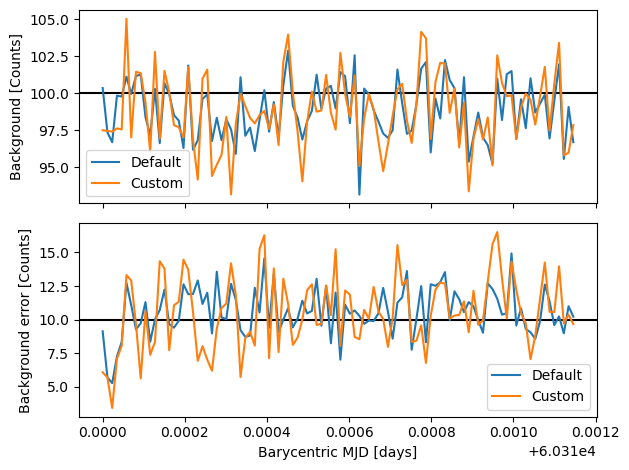

In [10]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(
    nrows=2,
    tight_layout=True,
    sharex=True,
    )

axes[0].plot(
    default_g_band_source_2_df['TDB'],
    default_g_band_source_2_df['background'],
    label='Default',
)
axes[0].plot(
    custom_g_band_source_2_df['TDB'],
    custom_g_band_source_2_df['background'],
    label='Custom',
)
axes[0].axhline(
    100,
    color='k',
    zorder=0,
)

axes[1].plot(
    default_g_band_source_2_df['TDB'],
    default_g_band_source_2_df['background_error'],
    label='Default',
)
axes[1].plot(
    custom_g_band_source_2_df['TDB'],
    custom_g_band_source_2_df['background_error'],
    label='Custom',
)
axes[1].axhline(
    10,
    color='k',
    zorder=0,
)

axes[1].set_xlabel('Barycentric MJD [days]')
axes[0].set_ylabel('Background [Counts]')
axes[1].set_ylabel('Background error [Counts]')

axes[0].legend()
axes[1].legend()

plt.show()

As we can see, both methods are around the expected values, and so either local background estimator would likely give pretty good results if applied to real data.

That concludes the local background tutorial for `opticam_new`! Much of the heavy lifting here is handled by `photutils`, so I'd highly recommend checking out their documentation for more information (specifically the Aperture Photometry page: https://photutils.readthedocs.io/en/stable/aperture.html).